# K-Means for Hearing Threshold Data Clustering: Older Adults Aged 60 or Above

## The 500 Hz data will be excluded

`Each participant's both ears are treated as if they were two participants.`

In [43]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

import seaborn as sns
import numpy as np

In [44]:
# Load the data
file_path = "../../data/nhanes_1520_age.csv"
data = pd.read_csv(file_path)
data = data[data['RIDAGEYR'] >= 60]
data.set_index('SEQN', inplace=True)
print(data.shape)
data.head()

(2410, 15)


,AUXU500R,AUXU1K1R,AUXU2KR,AUXU3KR,AUXU4KR,AUXU6KR,AUXU8KR,AUXU500L,AUXU1K1L,AUXU2KL,AUXU3KL,AUXU4KL,AUXU6KL,AUXU8KL,RIDAGEYR
SEQN,,,,,,,,,,,,,,,
83732,10.0,5.0,5.0,20.0,30.0,25.0,50.0,5.0,5.0,5.0,35.0,50.0,50.0,55.0,62
83754,10.0,20.0,10.0,10.0,20.0,25.0,40.0,10.0,15.0,5.0,10.0,15.0,30.0,25.0,67
83755,10.0,10.0,15.0,35.0,30.0,35.0,40.0,5.0,5.0,10.0,25.0,15.0,15.0,25.0,67
83775,55.0,60.0,50.0,50.0,50.0,70.0,75.0,65.0,60.0,50.0,60.0,65.0,75.0,65.0,69
83785,20.0,35.0,30.0,35.0,30.0,35.0,80.0,15.0,25.0,25.0,40.0,55.0,50.0,60.0,60


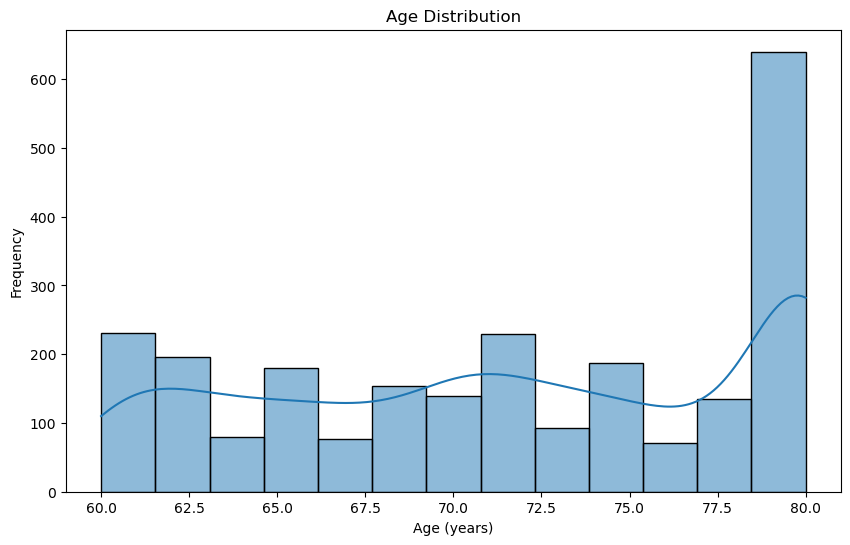

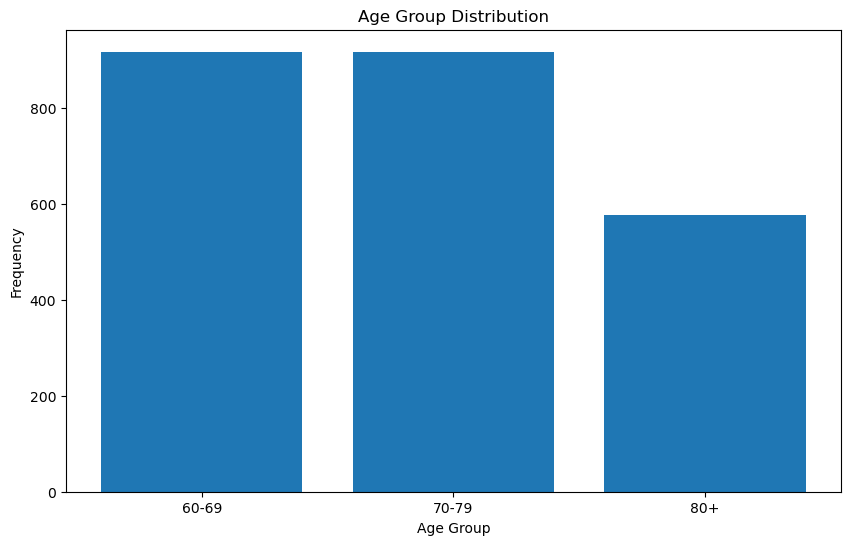

In [45]:
# Check the age distribution in the column 'RIDAGEYR'
plt.figure(figsize=(10, 6))
sns.histplot(data['RIDAGEYR'], kde=True)
plt.title('Age Distribution')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.show()

# Group age into 3 categories
data['age_group'] = pd.cut(data['RIDAGEYR'], bins=[60, 70, 80, 100], labels=['60-69', '70-79', '80+'], right = False)
data['age_group'].value_counts()

# Visualize the 3 categories
plt.figure(figsize=(10, 6))
plt.bar(data['age_group'].value_counts().index, data['age_group'].value_counts().values)
plt.title('Age Group Distribution')
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.show()

In [46]:
# Select the columns for right ear measurements

right_ear_columns = ['AUXU500R', 'AUXU1K1R', 'AUXU2KR', 'AUXU3KR', 'AUXU4KR', 'AUXU6KR', 'AUXU8KR']
right_ear_data = data[right_ear_columns]
right_ear_data.columns = ['500 Hz', '1 kHz', '2 kHz', '3 kHz', '4 kHz', '6 kHz', '8 kHz']

# Select the columns for left ear measurements

left_ear_columns = ['AUXU500L', 'AUXU1K1L', 'AUXU2KL', 'AUXU3KL', 'AUXU4KL', 'AUXU6KL', 'AUXU8KL']
left_ear_data = data[left_ear_columns]
left_ear_data.columns = ['500 Hz', '1 kHz', '2 kHz', '3 kHz', '4 kHz', '6 kHz', '8 kHz']

# Concatenate the right and left ear data

ear_data = pd.concat([right_ear_data, left_ear_data], axis = 0)

# Change the column names to be more descriptive

ear_data

,500 Hz,1 kHz,2 kHz,3 kHz,4 kHz,6 kHz,8 kHz
SEQN,,,,,,,
83732,10.0,5.0,5.0,20.0,30.0,25.0,50.0
83754,10.0,20.0,10.0,10.0,20.0,25.0,40.0
83755,10.0,10.0,15.0,35.0,30.0,35.0,40.0
83775,55.0,60.0,50.0,50.0,50.0,70.0,75.0
83785,20.0,35.0,30.0,35.0,30.0,35.0,80.0
...,...,...,...,...,...,...,...
124756,10.0,15.0,10.0,25.0,25.0,25.0,40.0
124784,45.0,50.0,50.0,50.0,50.0,45.0,80.0
124799,20.0,40.0,45.0,45.0,60.0,85.0,666.0


In [47]:
# Process missing values
cleaned_ear_data = ear_data.replace({888: np.nan, 666: np.nan, '.': np.nan}, inplace=False)
cleaned_ear_data = cleaned_ear_data.dropna(inplace=False)

# cleaned_ear_data.reset_index(drop=True, inplace=True)
cleaned_ear_data

,500 Hz,1 kHz,2 kHz,3 kHz,4 kHz,6 kHz,8 kHz
SEQN,,,,,,,
83732,10.0,5.0,5.0,20.0,30.0,25.0,50.0
83754,10.0,20.0,10.0,10.0,20.0,25.0,40.0
83755,10.0,10.0,15.0,35.0,30.0,35.0,40.0
83775,55.0,60.0,50.0,50.0,50.0,70.0,75.0
83785,20.0,35.0,30.0,35.0,30.0,35.0,80.0
...,...,...,...,...,...,...,...
124750,20.0,5.0,15.0,30.0,40.0,40.0,35.0
124756,10.0,15.0,10.0,25.0,25.0,25.0,40.0
124784,45.0,50.0,50.0,50.0,50.0,45.0,80.0


In [48]:
# Define frequencies and their differences
frequencies = ['500 Hz', '1 kHz', '2 kHz', '3 kHz', '4 kHz', '6 kHz', '8 kHz']
freq_differences = [500, 1000, 1000, 1000, 2000, 2000]  # Differences between frequencies
local_slope_data = cleaned_ear_data.copy()
global_slope_data = cleaned_ear_data.copy()

# Compute the subsequent columns
for i in range(1, len(frequencies)):
    local_slope_data[frequencies[i]] = (cleaned_ear_data[frequencies[i]] - cleaned_ear_data[frequencies[i - 1]]) / freq_differences[i - 1]
    global_slope_data[frequencies[i]] = (cleaned_ear_data[frequencies[i]] - cleaned_ear_data[frequencies[0]]) / sum(freq_differences[:i])

# Define an inverse function to transform slope data back to the original scale
def local_slope_inverse_transform(data):
    for i in range(1, len(frequencies)):
        data[frequencies[i]] = data[frequencies[i]] * freq_differences[i - 1] + data[frequencies[i - 1]]
    return data

def global_slope_inverse_transform(data):
    data_inverse = data.copy()
    for i in range(1, len(frequencies)):
        data[frequencies[i]] = data[frequencies[i]] * sum(freq_differences[:i]) + data[frequencies[0]]
    return data

local_slope_data.drop('500 Hz', axis=1, inplace=True)
global_slope_data.drop('500 Hz', axis=1, inplace=True)

local_slope_data.head()

,1 kHz,2 kHz,3 kHz,4 kHz,6 kHz,8 kHz
SEQN,,,,,,
83732,-0.01,0.000,0.015,0.010,-0.0025,0.0125
83754,0.02,-0.010,0.000,0.010,0.0025,0.0075
83755,0.00,0.005,0.020,-0.005,0.0025,0.0025
83775,0.01,-0.010,0.000,0.000,0.0100,0.0025
83785,0.03,-0.005,0.005,-0.005,0.0025,0.0225


In [49]:
global_slope_data.head()

,1 kHz,2 kHz,3 kHz,4 kHz,6 kHz,8 kHz
SEQN,,,,,,
83732,-0.01,-0.003333,0.004,0.005714,0.002727,0.005333
83754,0.02,0.000000,0.000,0.002857,0.002727,0.004000
83755,0.00,0.003333,0.010,0.005714,0.004545,0.004000
83775,0.01,-0.003333,-0.002,-0.001429,0.002727,0.002667
83785,0.03,0.006667,0.006,0.002857,0.002727,0.008000


In [50]:
# Standardize the data
standard_scaler = StandardScaler()
standard_scaled_data = standard_scaler.fit_transform(cleaned_ear_data)

# Min-max scaling
minmax_scaler = MinMaxScaler()
minmax_scaled_data = minmax_scaler.fit_transform(cleaned_ear_data)

# Robust scaling
## Note: Robust scaling is computed as (X - median) / IQR
robust_scaler = RobustScaler()
robust_scaled_data = robust_scaler.fit_transform(cleaned_ear_data)

# Quantile transformation
quantile_transformer = QuantileTransformer(output_distribution = 'normal')
quantile_transformed_data = quantile_transformer.fit_transform(cleaned_ear_data)

# K-Means with local slope data

KMeans with 2 clusters
Silhouette Score: 0.034
Davies Bouldin Score: 5.304
Calinski Harabasz Score: 112.427
-----------------------------------
KMeans with 3 clusters
Silhouette Score: 0.015
Davies Bouldin Score: 3.671
Calinski Harabasz Score: 256.756
-----------------------------------
KMeans with 4 clusters
Silhouette Score: -0.023
Davies Bouldin Score: 6.432
Calinski Harabasz Score: 236.318
-----------------------------------


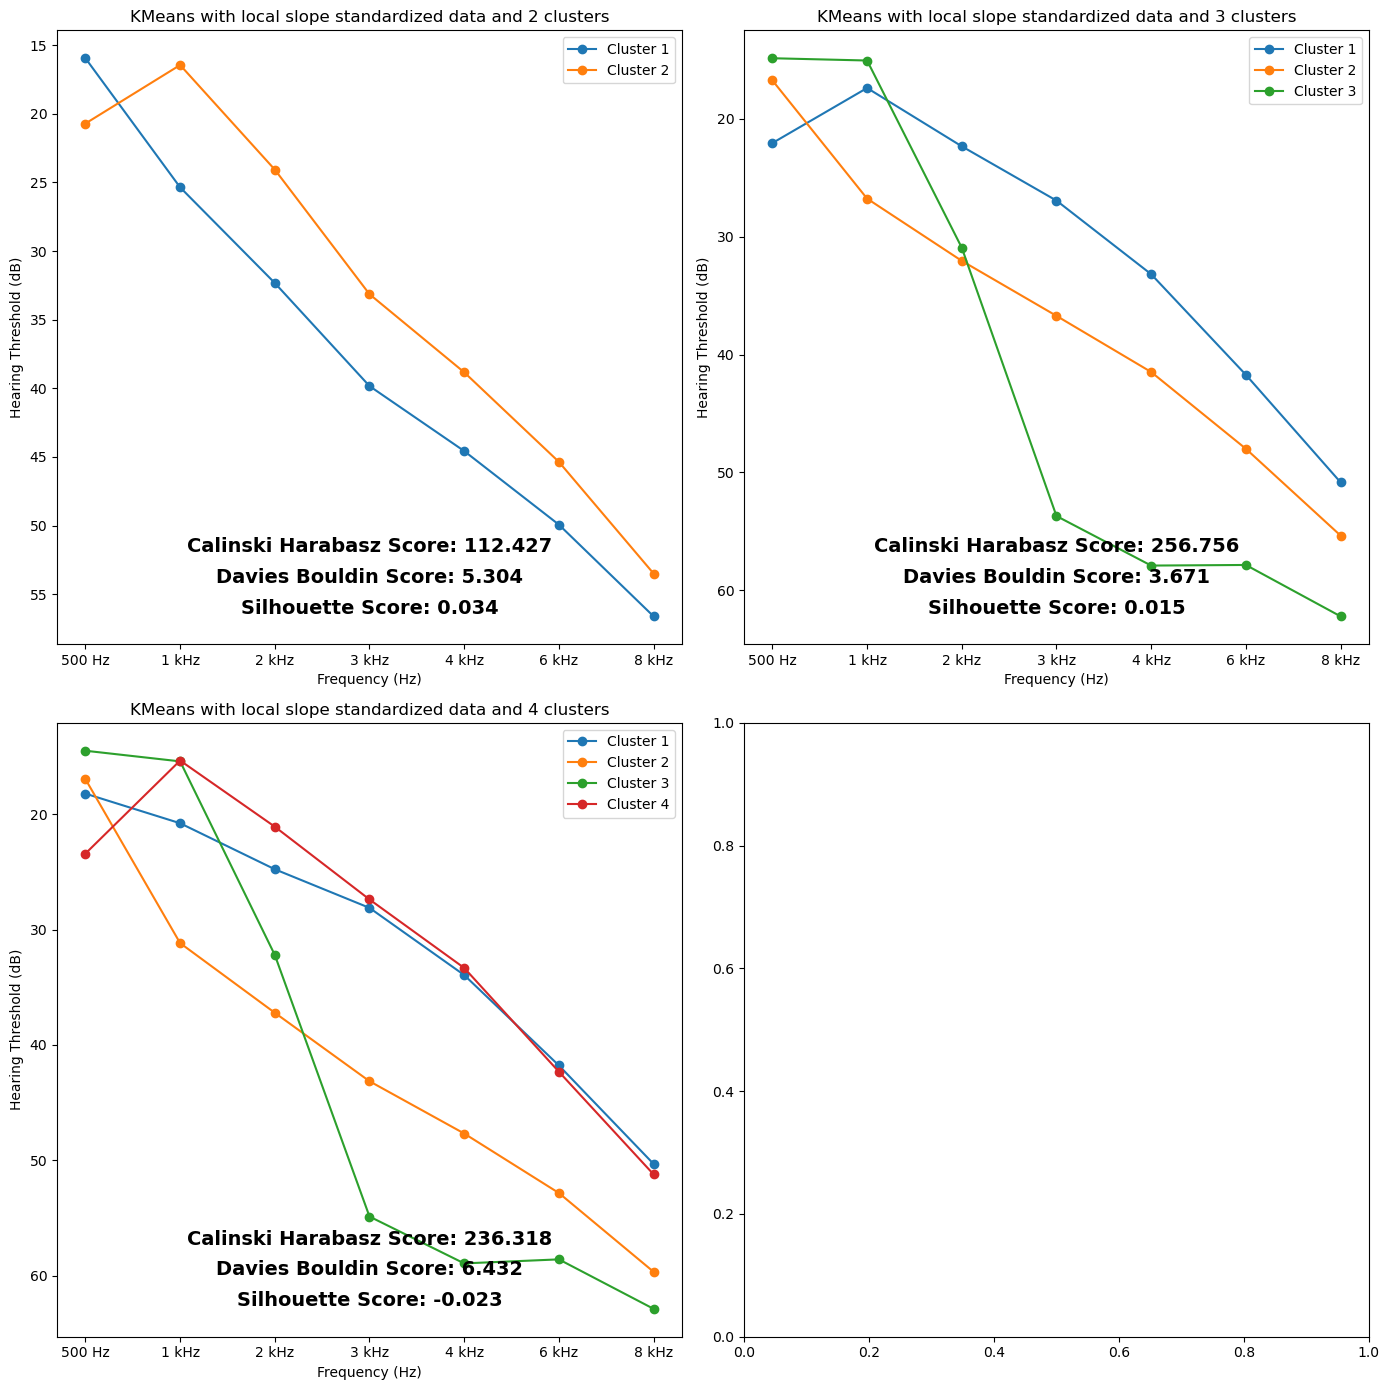

In [56]:
# Fit the K-Means algorithm with n clusters = 2, 3, 4

fig, ax = plt.subplots(2, 2, figsize=(14, 14)) # Create a 2x2 grid of subplots

for i in range(2, 5):
    # Initialize the KMeans object
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(local_slope_data)

    # Extract the centroids
    ear_df = cleaned_ear_data.copy()
    ear_df['label'] = kmeans.labels_
    centroids = ear_df.groupby('label').mean()
    centroids_df = pd.DataFrame(centroids, columns=cleaned_ear_data.columns)

    # Plot the line plot
    row = (i - 2) // 2
    col = (i - 2) % 2
    for cluster_id in range(i):
        ax[row, col].plot(
            centroids_df.columns,
            centroids_df.iloc[cluster_id],
            marker='o',
            label=f'Cluster {cluster_id + 1}'
        )
    ax[row, col].set_title(f'KMeans with local slope standardized data and {i} clusters')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Hearing Threshold (dB)')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Annotate the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}', 
                          xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=14, fontweight='bold')
    ax[row, col].annotate(f'Davies Bouldin Score: {davies_bouldin:.3f}',
                            xy=(0.5, 0.10), xycoords='axes fraction', ha='center', fontsize=14, fontweight='bold')
    ax[row, col].annotate(f'Calinski Harabasz Score: {calinski_harabasz:.3f}',
                            xy=(0.5, 0.15), xycoords='axes fraction', ha='center', fontsize=14, fontweight='bold')
    
    # Print out the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    print(f'KMeans with {i} clusters')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies Bouldin Score: {davies_bouldin:.3f}')
    print(f'Calinski Harabasz Score: {calinski_harabasz:.3f}')
    print('-' * 35)

plt.tight_layout()
plt.show()

# K-Means with global slope data

KMeans with 2 clusters
Silhouette Score: 0.063
Davies Bouldin Score: 3.463
Calinski Harabasz Score: 261.855
-----------------------------------
KMeans with 3 clusters
Silhouette Score: -0.016
Davies Bouldin Score: 5.598
Calinski Harabasz Score: 236.110
-----------------------------------
KMeans with 4 clusters
Silhouette Score: -0.027
Davies Bouldin Score: 6.248
Calinski Harabasz Score: 344.729
-----------------------------------


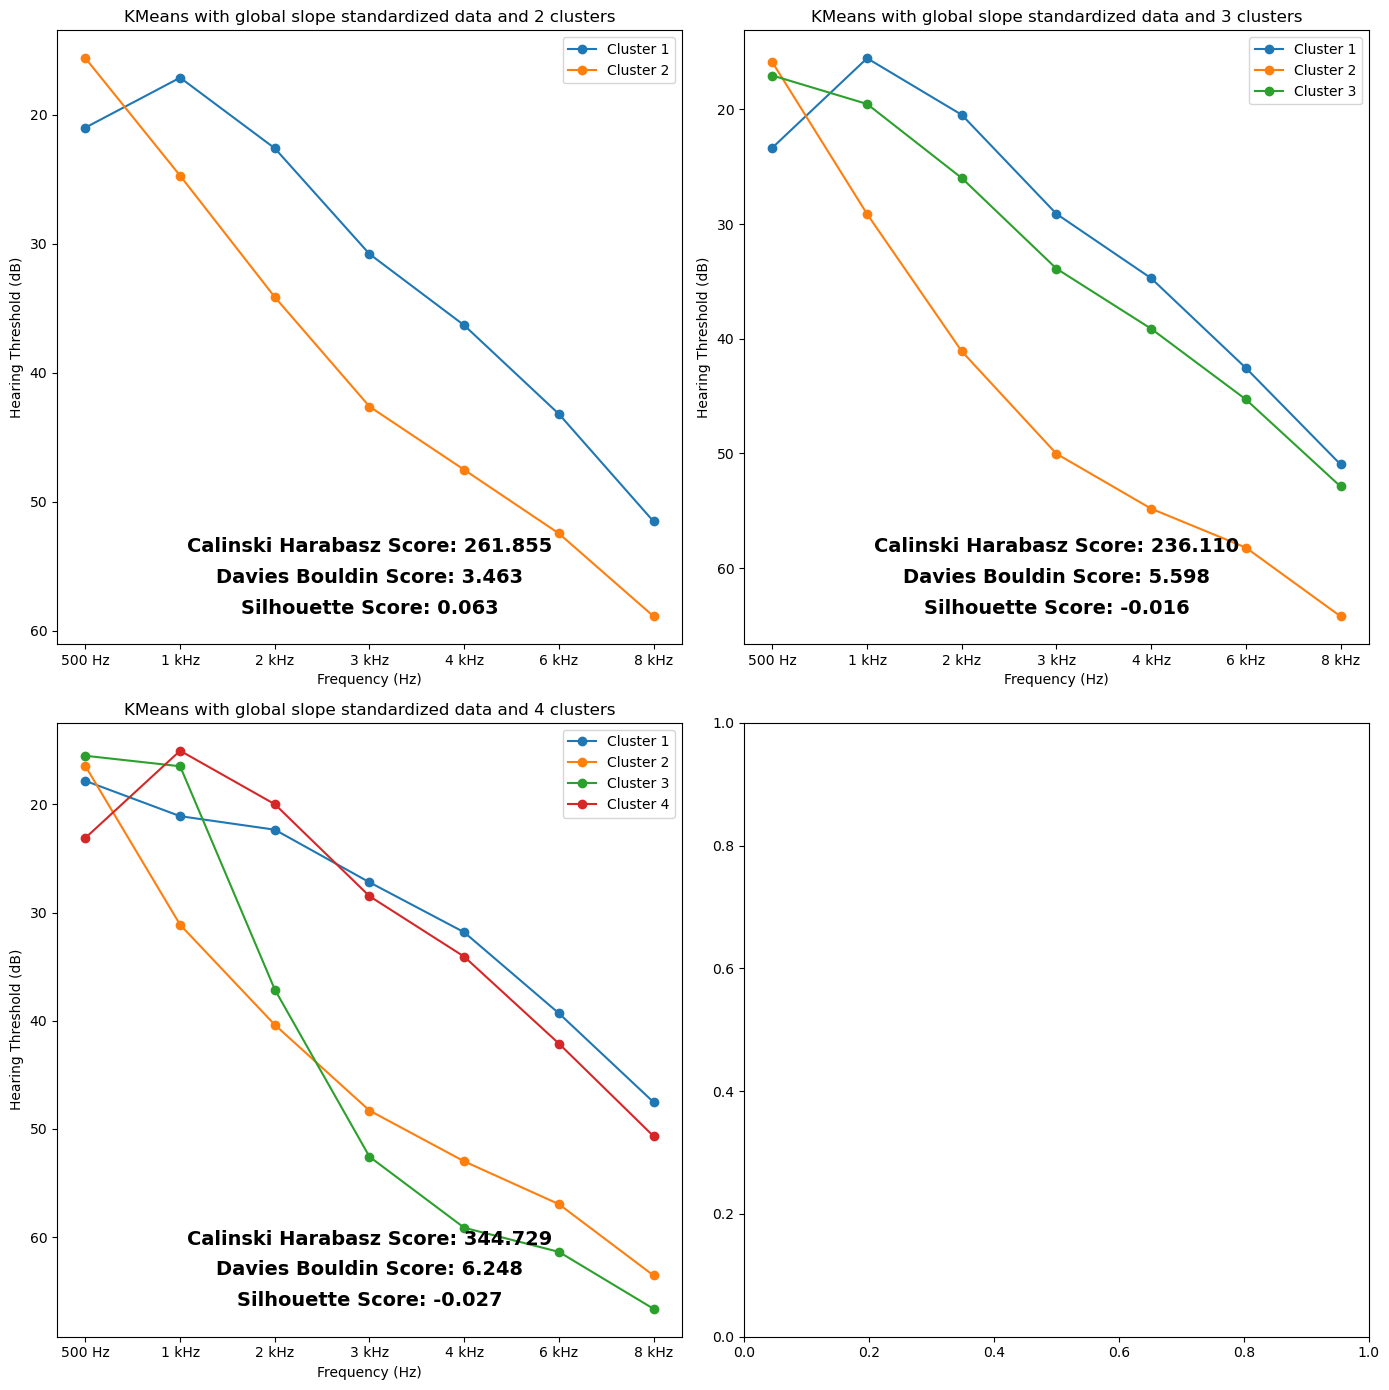

In [55]:
# Fit the K-Means algorithm with n clusters = 2, 3, 4

fig, ax = plt.subplots(2, 2, figsize=(14, 14)) # Create a 2x2 grid of subplots

for i in range(2, 5):
    # Initialize the KMeans object
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(global_slope_data)

    # Extract the centroids
    ear_df = cleaned_ear_data.copy()
    ear_df['label'] = kmeans.labels_
    centroids = ear_df.groupby('label').mean()
    centroids_df = pd.DataFrame(centroids, columns=cleaned_ear_data.columns)

    # Plot the line plot
    row = (i - 2) // 2
    col = (i - 2) % 2
    for cluster_id in range(i):
        ax[row, col].plot(
            centroids_df.columns,
            centroids_df.iloc[cluster_id],
            marker='o',
            label=f'Cluster {cluster_id + 1}'
        )
    ax[row, col].set_title(f'KMeans with global slope standardized data and {i} clusters')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Hearing Threshold (dB)')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Annotate the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}', 
                          xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=14, fontweight='bold')
    ax[row, col].annotate(f'Davies Bouldin Score: {davies_bouldin:.3f}',
                            xy=(0.5, 0.10), xycoords='axes fraction', ha='center', fontsize=14, fontweight='bold')
    ax[row, col].annotate(f'Calinski Harabasz Score: {calinski_harabasz:.3f}',
                            xy=(0.5, 0.15), xycoords='axes fraction', ha='center', fontsize=14, fontweight='bold')
    
    # Print out the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    print(f'KMeans with {i} clusters')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies Bouldin Score: {davies_bouldin:.3f}')
    print(f'Calinski Harabasz Score: {calinski_harabasz:.3f}')
    print('-' * 35)

plt.tight_layout()
plt.show()

# K-Means with raw data

KMeans with 2 clusters
Silhouette Score: 0.410
Davies Bouldin Score: 0.926
Calinski Harabasz Score: 3878.312
--------------------------------------------------
KMeans with 3 clusters
Silhouette Score: 0.303
Davies Bouldin Score: 1.142
Calinski Harabasz Score: 3085.711
--------------------------------------------------
KMeans with 4 clusters
Silhouette Score: 0.235
Davies Bouldin Score: 1.330
Calinski Harabasz Score: 2536.358
--------------------------------------------------


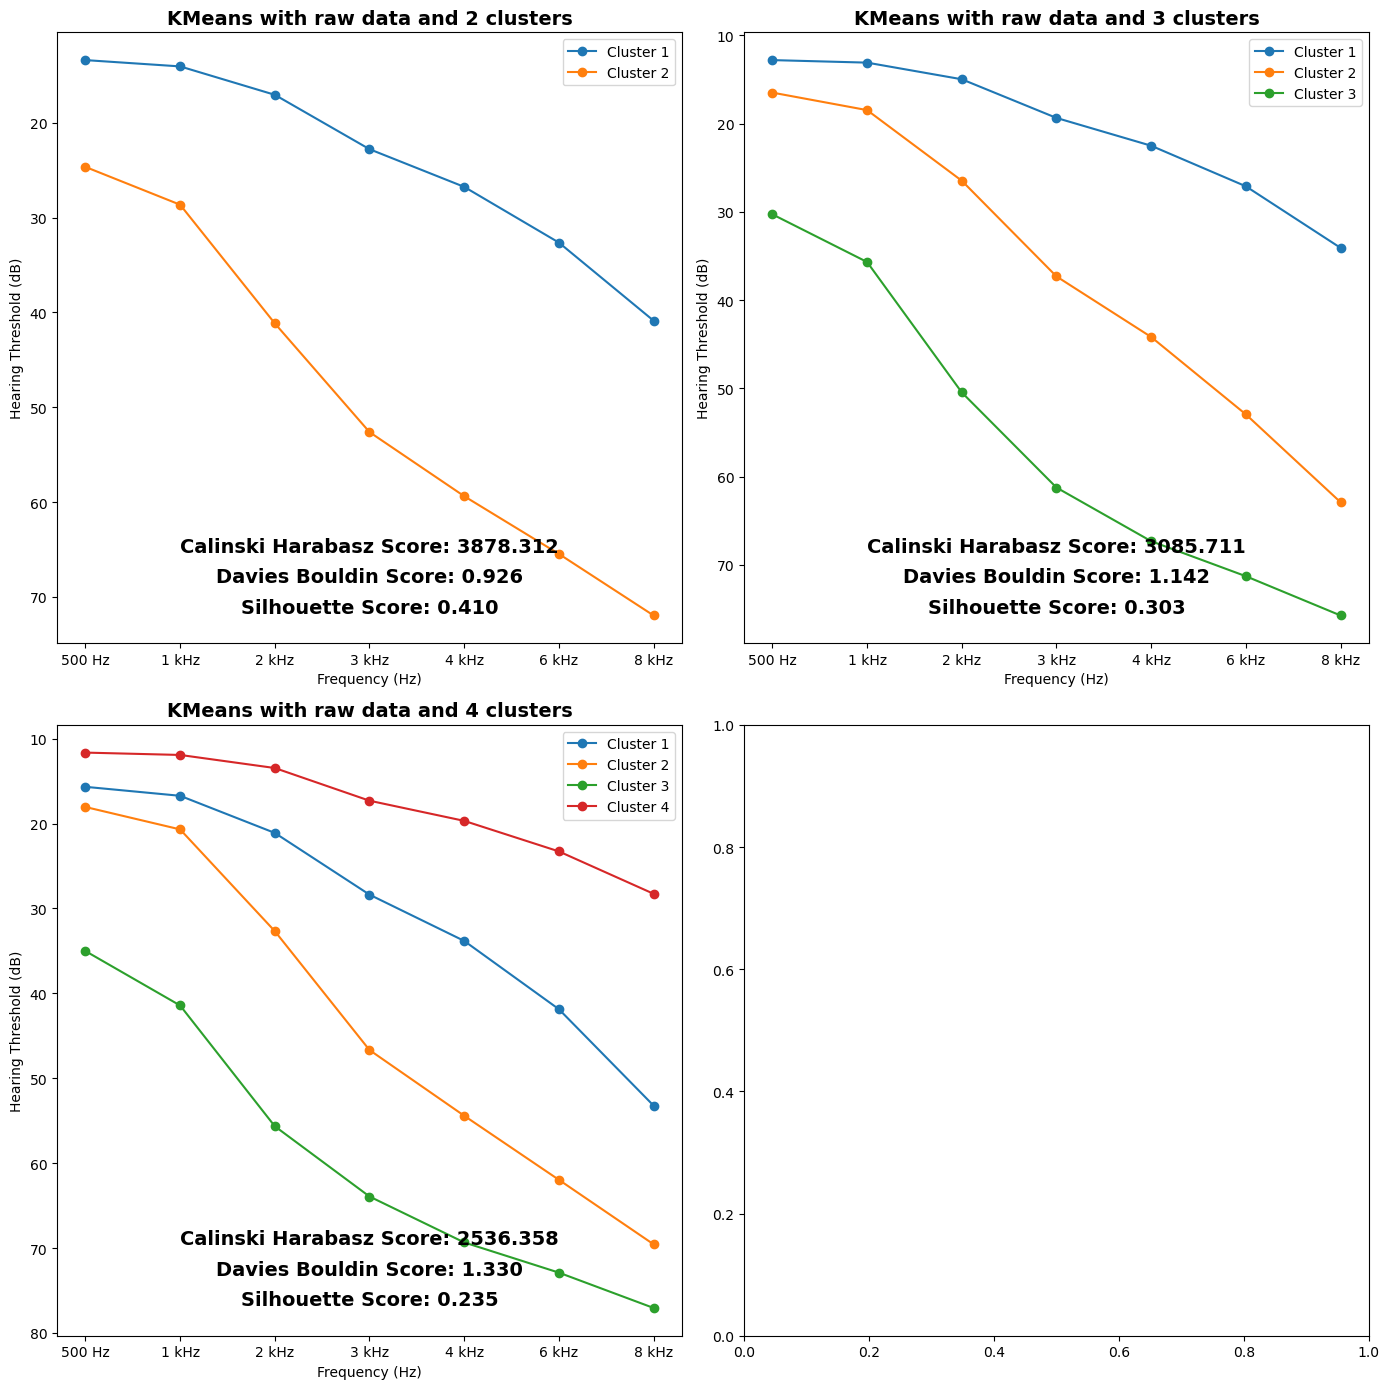

In [57]:
# Fit the K-Means algorithm with n clusters = 2, 3, 4

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for i in range(2, 5):
    # Initialize the KMeans object
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(cleaned_ear_data)

    # Extract the centroids
    centroids = kmeans.cluster_centers_
    centroids_df = pd.DataFrame(centroids, columns=ear_data.columns)

    # Plot the line plot
    row = (i - 2) // 2
    col = (i - 2) % 2
    for cluster_id in range(i):
        ax[row, col].plot(
            centroids_df.columns, 
            centroids_df.iloc[cluster_id], 
            marker='o', 
            label=f'Cluster {cluster_id + 1}'
        )
    ax[row, col].set_title(f'KMeans with raw data and {i} clusters', fontsize = 14, fontweight = 'bold')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Hearing Threshold (dB)')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Annotate the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}', 
                          xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=14, fontweight='bold')
    ax[row, col].annotate(f'Davies Bouldin Score: {davies_bouldin:.3f}',
                            xy=(0.5, 0.10), xycoords='axes fraction', ha='center', fontsize=14, fontweight='bold')
    ax[row, col].annotate(f'Calinski Harabasz Score: {calinski_harabasz:.3f}',
                            xy=(0.5, 0.15), xycoords='axes fraction', ha='center', fontsize=14, fontweight='bold')
    
    # Print out the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    print(f'KMeans with {i} clusters')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies Bouldin Score: {davies_bouldin:.3f}')
    print(f'Calinski Harabasz Score: {calinski_harabasz:.3f}')
    print('-' * 50)

plt.tight_layout()
plt.show()

# K-Means with z-score centered data

KMeans with 2 clusters
Silhouette Score: 0.405
Davies Bouldin Score: 0.934
Calinski Harabasz Score: 3775.086
--------------------------------------------------
KMeans with 3 clusters
Silhouette Score: 0.310
Davies Bouldin Score: 1.175
Calinski Harabasz Score: 2911.064
--------------------------------------------------
KMeans with 4 clusters
Silhouette Score: 0.250
Davies Bouldin Score: 1.327
Calinski Harabasz Score: 2448.683
--------------------------------------------------


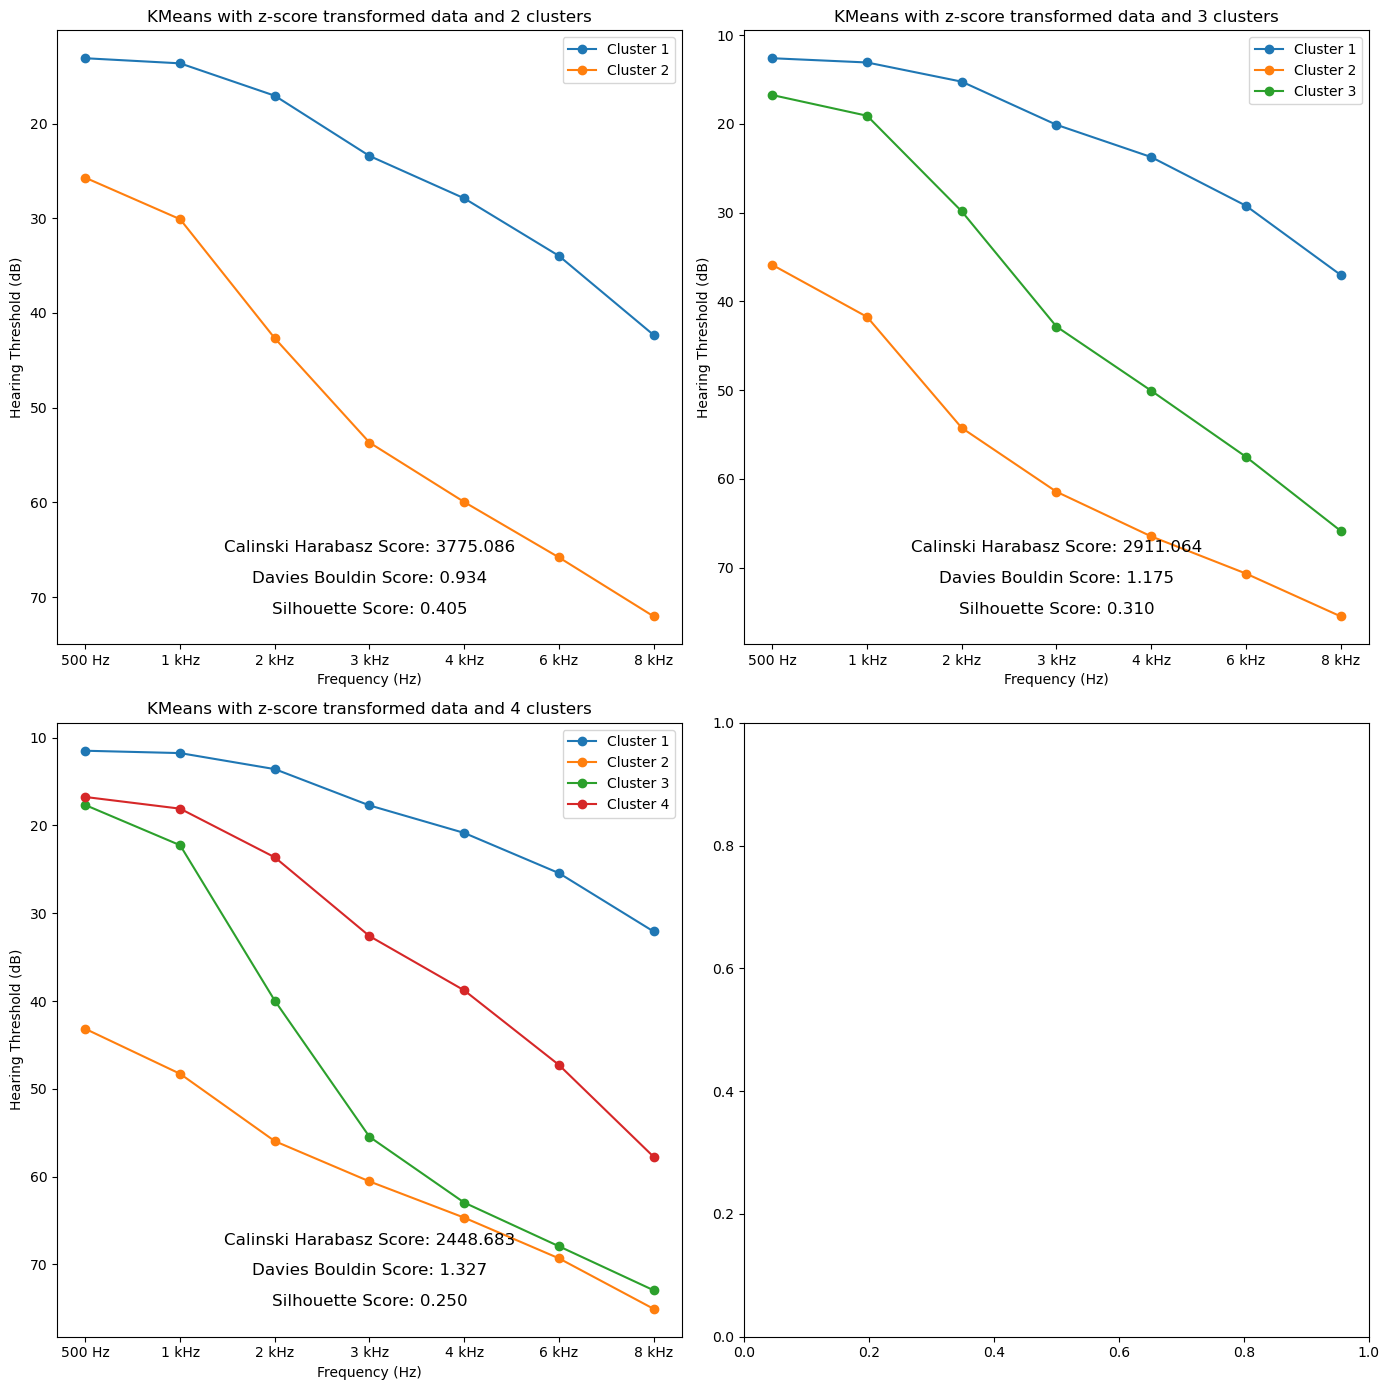

In [12]:
# Fit the K-Means algorithm with n clusters = 2, 3, 4

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for i in range(2, 5):
    # Initialize the KMeans object
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(standard_scaled_data)

    # Extract the centroids
    centroids = standard_scaler.inverse_transform(kmeans.cluster_centers_)
    centroids_df = pd.DataFrame(centroids, columns=ear_data.columns)

    # Plot the line plot
    row = (i - 2) // 2
    col = (i - 2) % 2
    for cluster_id in range(i):
        ax[row, col].plot(
            centroids_df.columns, 
            centroids_df.iloc[cluster_id], 
            marker='o', 
            label=f'Cluster {cluster_id + 1}'
        )
    ax[row, col].set_title(f'KMeans with z-score transformed data and {i} clusters')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Hearing Threshold (dB)')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Annotate the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}', 
                          xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Davies Bouldin Score: {davies_bouldin:.3f}',
                            xy=(0.5, 0.10), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Calinski Harabasz Score: {calinski_harabasz:.3f}',
                            xy=(0.5, 0.15), xycoords='axes fraction', ha='center', fontsize=12)
    
    # Print out the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    print(f'KMeans with {i} clusters')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies Bouldin Score: {davies_bouldin:.3f}')
    print(f'Calinski Harabasz Score: {calinski_harabasz:.3f}')
    print('-' * 50)

plt.tight_layout()
plt.show()

## KMeans with min-max standardized data

KMeans with 2 clusters
Silhouette Score: 0.409
Davies Bouldin Score: 0.927
Calinski Harabasz Score: 3873.862
--------------------------------------------------
KMeans with 3 clusters
Silhouette Score: 0.301
Davies Bouldin Score: 1.134
Calinski Harabasz Score: 3073.118
--------------------------------------------------
KMeans with 4 clusters
Silhouette Score: 0.238
Davies Bouldin Score: 1.321
Calinski Harabasz Score: 2527.021
--------------------------------------------------


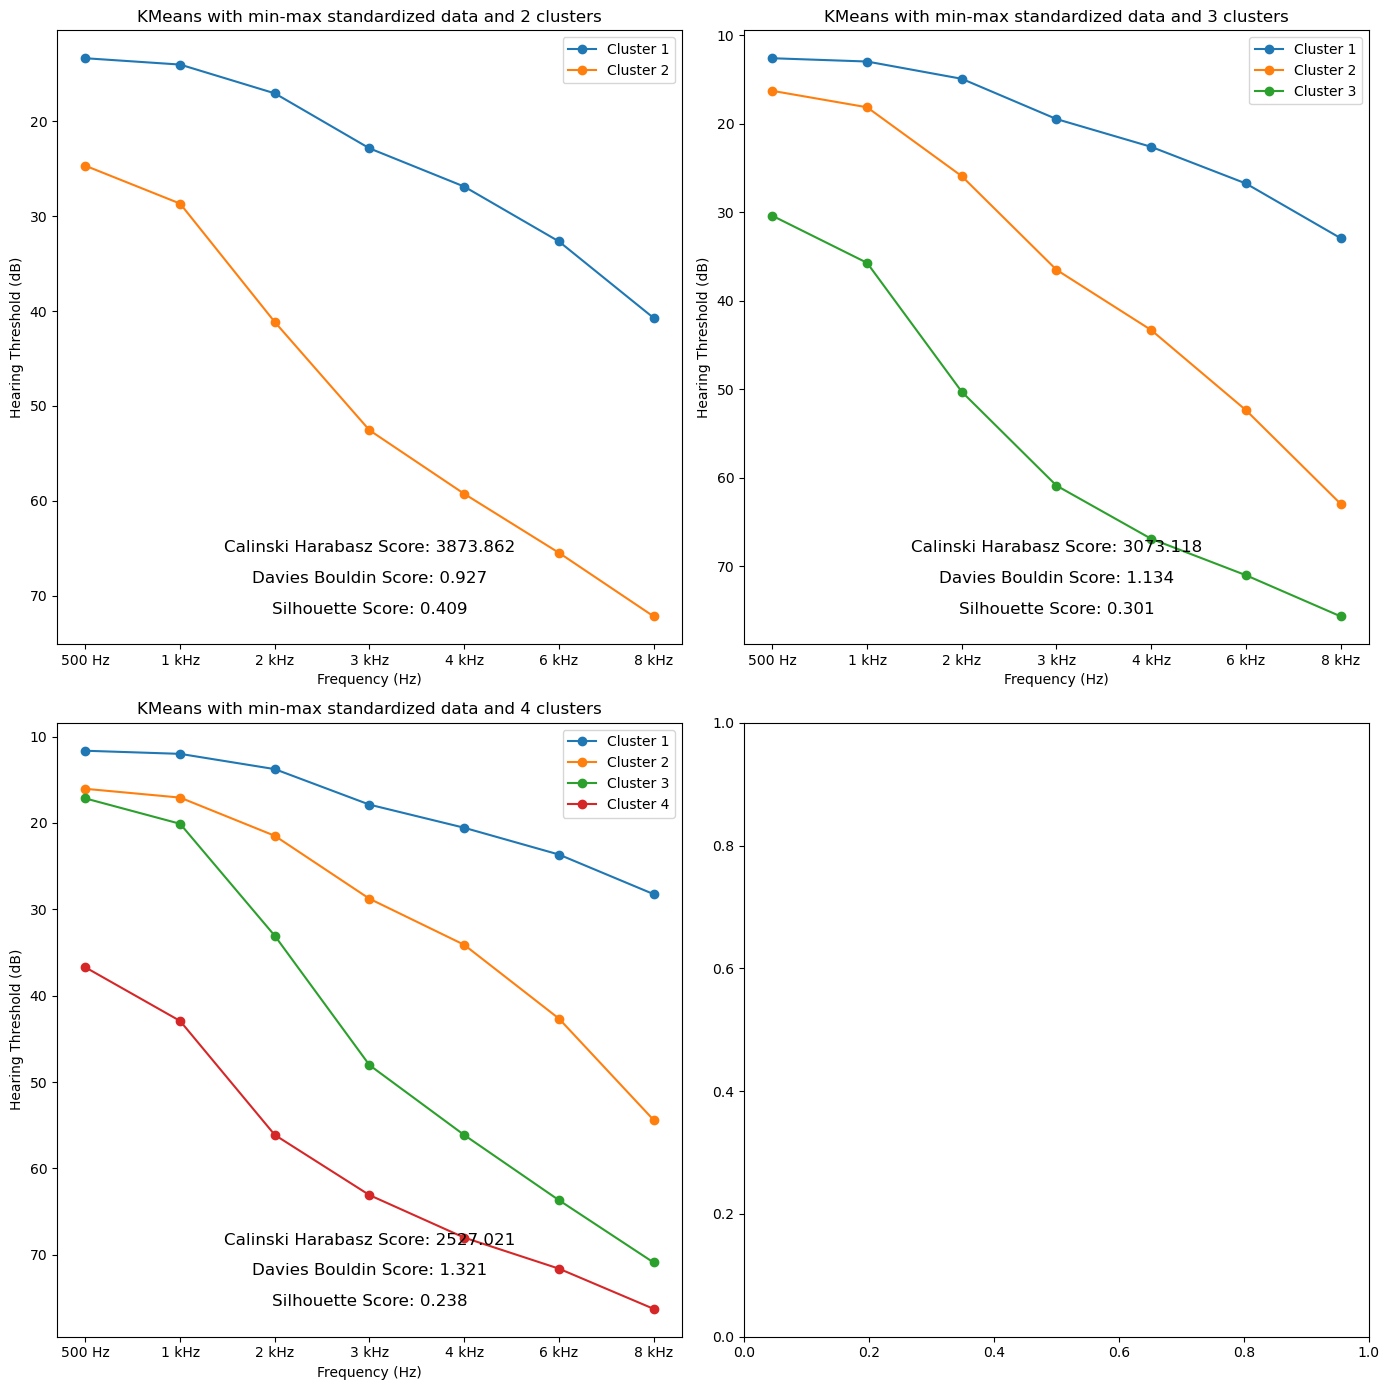

In [13]:
# K-Means with min-max standardized data

# Fit the K-Means algorithm with n clusters = 2, 3, 4

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for i in range(2, 5):
    # Initialize the KMeans object
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(minmax_scaled_data)

    # Extract the centroids
    centroids = minmax_scaler.inverse_transform(kmeans.cluster_centers_)
    centroids_df = pd.DataFrame(centroids, columns=ear_data.columns)

    # Plot the line plot
    row = (i - 2) // 2
    col = (i - 2) % 2
    for cluster_id in range(i):
        ax[row, col].plot(
            centroids_df.columns, 
            centroids_df.iloc[cluster_id], 
            marker='o', 
            label=f'Cluster {cluster_id + 1}'
        )
    ax[row, col].set_title(f'KMeans with min-max standardized data and {i} clusters')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Hearing Threshold (dB)')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Annotate the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}', 
                          xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Davies Bouldin Score: {davies_bouldin:.3f}',
                            xy=(0.5, 0.10), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Calinski Harabasz Score: {calinski_harabasz:.3f}',
                            xy=(0.5, 0.15), xycoords='axes fraction', ha='center', fontsize=12)
    
    # Print out the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    print(f'KMeans with {i} clusters')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies Bouldin Score: {davies_bouldin:.3f}')
    print(f'Calinski Harabasz Score: {calinski_harabasz:.3f}')
    print('-' * 50)

plt.tight_layout()
plt.show()

# K-Means with robust scaled data

Robust scaling is computed as: (x - median) / IQR

KMeans with 2 clusters
Silhouette Score: 0.391
Davies Bouldin Score: 0.960
Calinski Harabasz Score: 3510.498
--------------------------------------------------
KMeans with 3 clusters
Silhouette Score: 0.309
Davies Bouldin Score: 1.239
Calinski Harabasz Score: 2664.354
--------------------------------------------------
KMeans with 4 clusters
Silhouette Score: 0.242
Davies Bouldin Score: 1.373
Calinski Harabasz Score: 2369.904
--------------------------------------------------


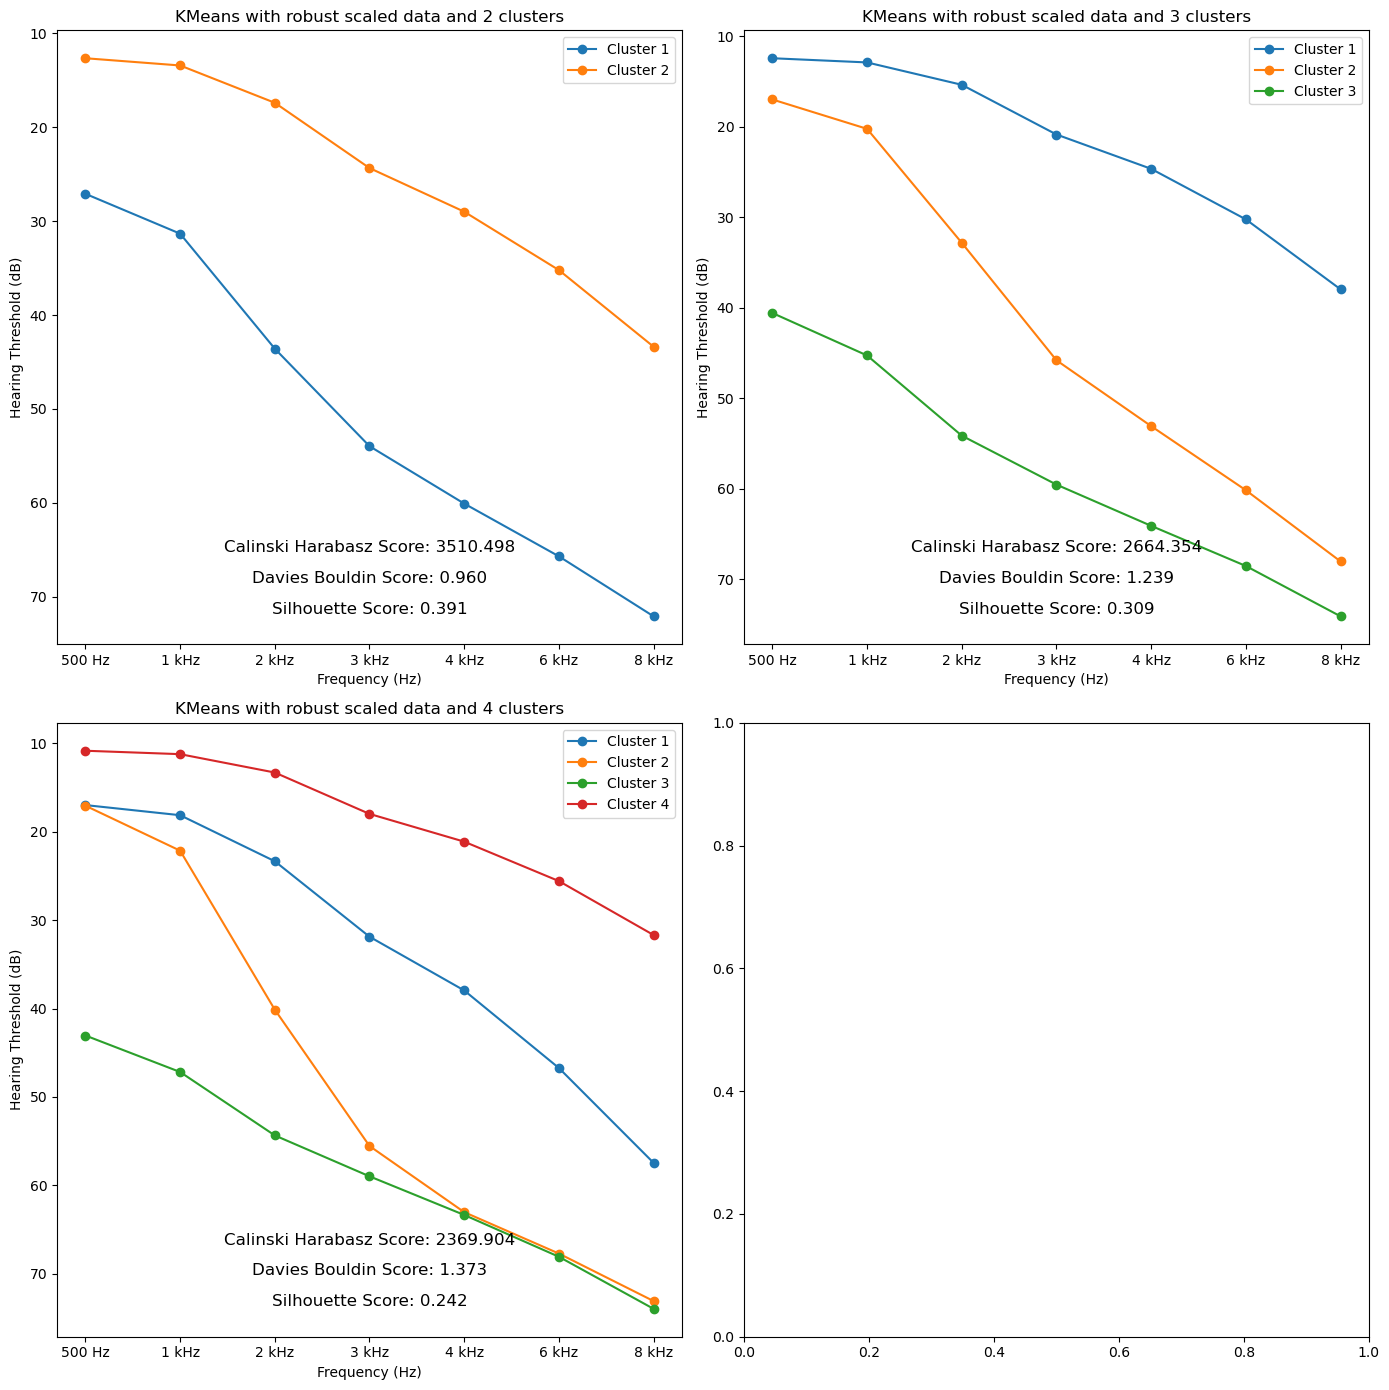

In [14]:
# K-Means with robust standardized data

# Fit the K-Means algorithm with n clusters = 2, 3, 4

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for i in range(2, 5):
    # Initialize the KMeans object
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(robust_scaled_data)

    # Extract the centroids
    centroids = robust_scaler.inverse_transform(kmeans.cluster_centers_)
    centroids_df = pd.DataFrame(centroids, columns=ear_data.columns)

    # Plot the line plot
    row = (i - 2) // 2
    col = (i - 2) % 2
    for cluster_id in range(i):
        ax[row, col].plot(
            centroids_df.columns, 
            centroids_df.iloc[cluster_id], 
            marker='o', 
            label=f'Cluster {cluster_id + 1}'
        )
    ax[row, col].set_title(f'KMeans with robust scaled data and {i} clusters')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Hearing Threshold (dB)')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Annotate the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}', 
                          xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Davies Bouldin Score: {davies_bouldin:.3f}',
                            xy=(0.5, 0.10), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Calinski Harabasz Score: {calinski_harabasz:.3f}',
                            xy=(0.5, 0.15), xycoords='axes fraction', ha='center', fontsize=12)
    
    # Print out the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    print(f'KMeans with {i} clusters')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies Bouldin Score: {davies_bouldin:.3f}')
    print(f'Calinski Harabasz Score: {calinski_harabasz:.3f}')
    print('-' * 50)

plt.tight_layout()
plt.show()

## K-Mean clustering with QuantileTransformed

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


KMeans with 2 clusters
Silhouette Score: 0.393
Davies Bouldin Score: 0.952
Calinski Harabasz Score: 3644.071
--------------------------------------------------
KMeans with 3 clusters
Silhouette Score: 0.276
Davies Bouldin Score: 1.165
Calinski Harabasz Score: 2845.501
--------------------------------------------------


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


KMeans with 4 clusters
Silhouette Score: 0.201
Davies Bouldin Score: 1.399
Calinski Harabasz Score: 2190.328
--------------------------------------------------


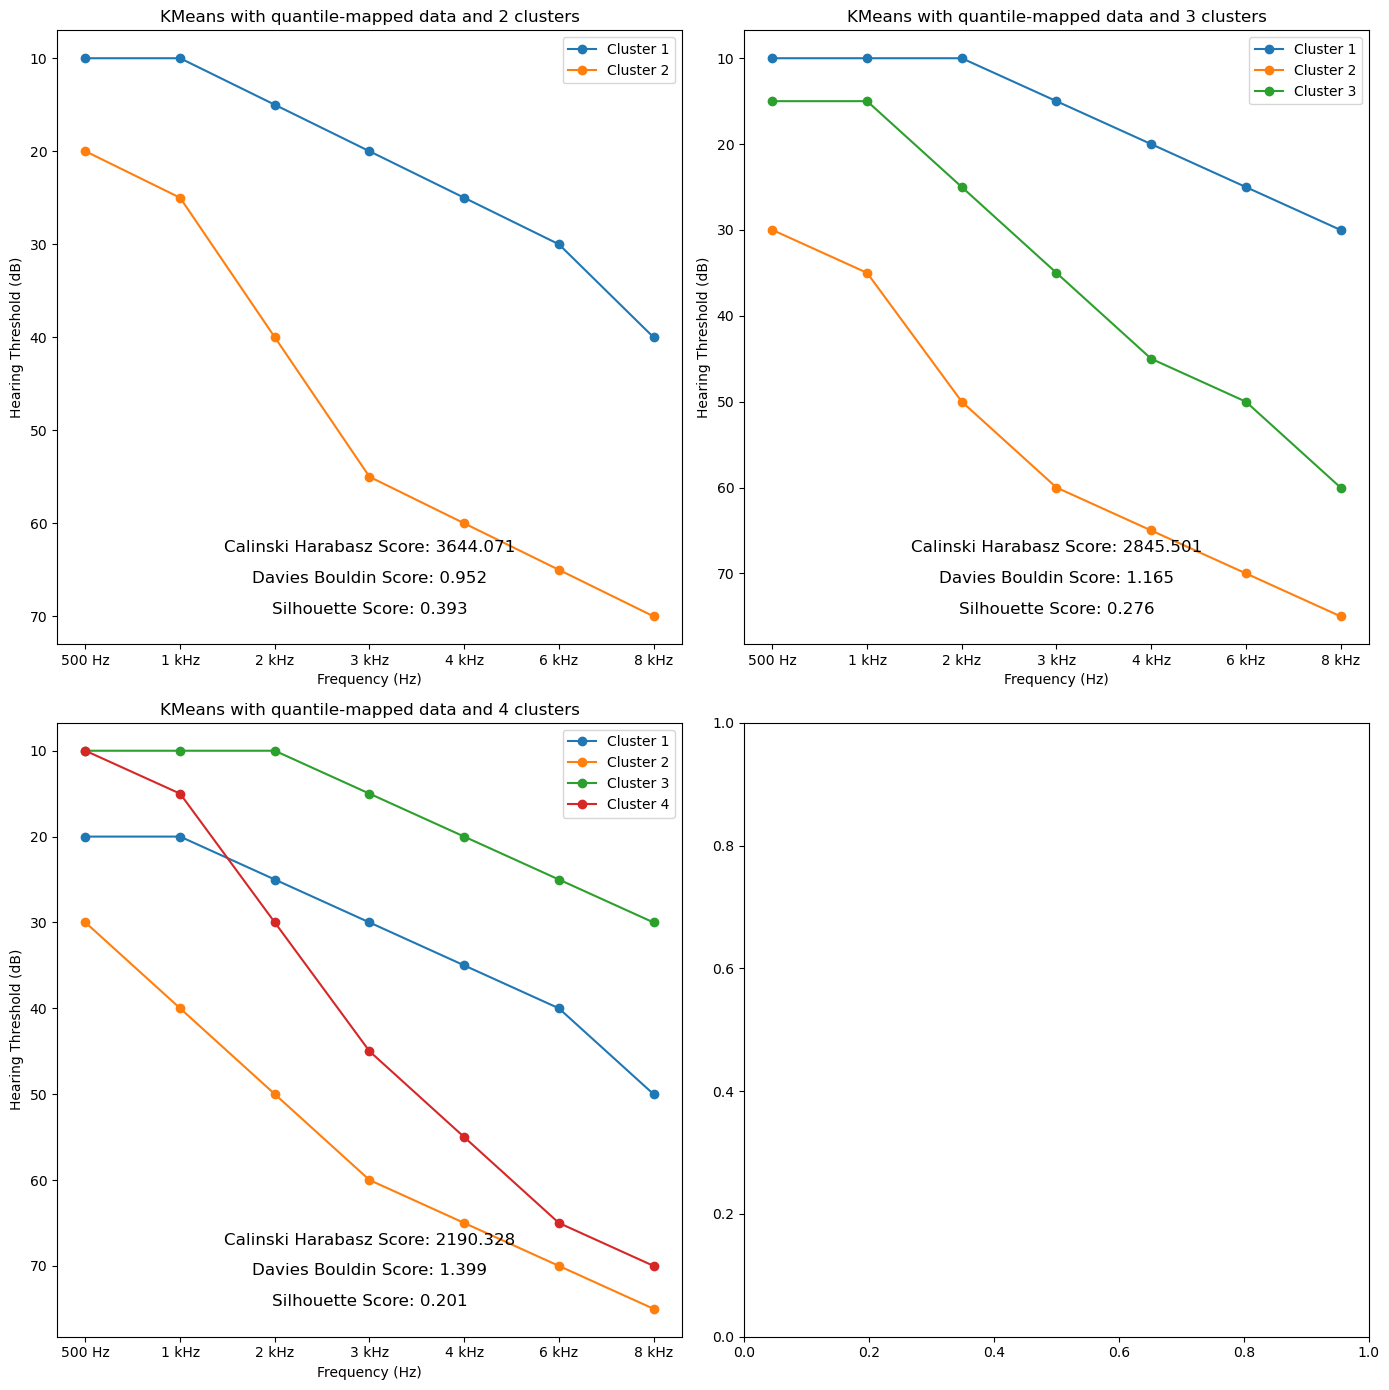

In [15]:
# K-Means with quantile standardized data

# Fit the K-Means algorithm with n clusters = 2, 3, 4

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for i in range(2, 5):
    # Initialize the KMeans object
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(quantile_transformed_data)

    # Extract the centroids
    centroids = quantile_transformer.inverse_transform(kmeans.cluster_centers_)
    centroids_df = pd.DataFrame(centroids, columns=ear_data.columns)

    # Plot the line plot
    row = (i - 2) // 2
    col = (i - 2) % 2
    for cluster_id in range(i):
        ax[row, col].plot(
            centroids_df.columns, 
            centroids_df.iloc[cluster_id], 
            marker='o', 
            label=f'Cluster {cluster_id + 1}'
        )
    ax[row, col].set_title(f'KMeans with quantile-mapped data and {i} clusters')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Hearing Threshold (dB)')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Annotate the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}', 
                          xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Davies Bouldin Score: {davies_bouldin:.3f}',
                            xy=(0.5, 0.10), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Calinski Harabasz Score: {calinski_harabasz:.3f}',
                            xy=(0.5, 0.15), xycoords='axes fraction', ha='center', fontsize=12)
    
    # Print out the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    print(f'KMeans with {i} clusters')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies Bouldin Score: {davies_bouldin:.3f}')
    print(f'Calinski Harabasz Score: {calinski_harabasz:.3f}')
    print('-' * 50)

plt.tight_layout()
plt.show()